/opt/conda/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/opt/conda/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


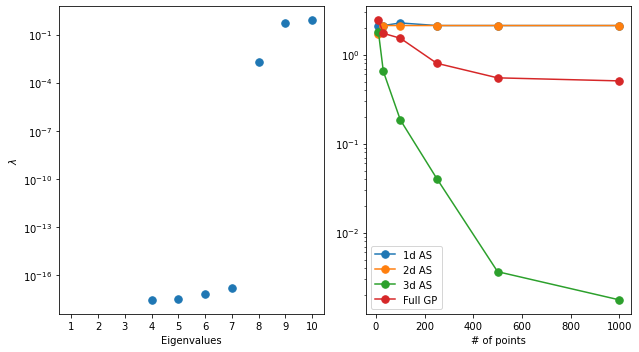

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

"""
Scheidegger & Bilionis (2017), 
Machine Learning for High-Dimensional Dynamic Stochastic Economies

https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2927400

This example is slightly different than what S&B present in that I plot the maximum 
absolute error on the 1,000 random testing points instead of 
what they refer to as the average error.
"""


def test_old(x):
    return np.exp(0.01*x[0] + 0.7*x[1] + 0.02*x[2] + 0.03*x[3] + 0.04*x[4] + 
                  0.05*x[5] + 0.06*x[6] + 0.08*x[7] + 0.09*x[8] + 0.1*x[9])


def test_function(x):
    return x[1]*x[2] * np.exp(0.01*x[0] + 0.7*x[1] + 0.02*x[2] + 0.03*x[3] + 0.04*x[4] + 
                  0.05*x[5] + 0.06*x[6] + 0.08*x[7] + 0.09*x[8] + 0.1*x[9])

def dtest_function(x):
    _test_old = test_old(x)
    val = np.atleast_1d(x[1] * x[2] * _test_old)
    coefs = np.array([0.01, 0.7, 0.02, 0.03, 0.04, 0.05, 0.06, 0.08, 0.09, 0.1])
    out = val[:, None] * coefs[None, :]
    out[:, 1] += x[2] * _test_old
    out[:, 2] += x[1] * _test_old
    return out


#Evaluating this function on points in \Omega = [-1,1]^2
def randOmega(N, D):
    "random points on \Omega = [-1,1]^D"
    return 2 * (np.random.rand(N, D) - 0.5)

def test_case():
    np.random.seed(42)
    Nvals = np.array([10, 30, 100, 250, 500, 1000])
    num_Ns = len(Nvals)
    max_errs = np.inf * np.ones((num_Ns, 3))
    max_errs_gp = np.inf * np.ones(num_Ns)
    
    # construct test points
    X_test = randOmega(1000, 10)
    f_test = test_function(X_test.T)

    for i, N in enumerate(Nvals):
        # training points
        X = randOmega(int(N), 10)
        V = test_function(X.T)
        G = dtest_function(X.T)
    
        CN = (G.T @ G) / N
        vals, vecs = linalg.eigh(CN)
        for d in range(3, 0, -1):

            # find active subspace of dimension d
            W = vecs[:, -d:]
            Y = X @ W

            # fit GP on active subspace
            gp_as = GaussianProcessRegressor(RBF(), n_restarts_optimizer=0)
            gp_as.fit(Y.reshape(N, d), V)
            m_tilde = gp_as.predict((X_test @ W).reshape(1000, d))
            max_errs[i, d-1] = np.max(np.abs(f_test - m_tilde))
        
        gp = GaussianProcessRegressor(RBF())
        gp.fit(X, V)
        m_tilde = gp.predict(X_test)
        max_errs_gp[i] = np.max(np.abs(f_test - m_tilde))
    
    fig, ax = plt.subplots(1, 2, figsize=(9, 5))
    x = np.arange(1, 11)
    ax[0].semilogy(x, vals, ".", ms=15)
    ax[0].set_xlabel("Eigenvalues")
    ax[0].set_xticks(x)
    ax[0].set_ylabel("$\lambda$")
    
    ax[1].semilogy(Nvals, max_errs, ".-", ms=15)
    ax[1].semilogy(Nvals, max_errs_gp, ".-", ms=15)
    ax[1].legend([str(i) + "d AS" for i in range(1, 4)] + ["Full GP"])
    ax[1].set_xlabel("# of points")

    fig.tight_layout()
    plt.show()
    return fig, max_errs


figure, max_errs = test_case()